✅ Total images: 3264
class
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64
📊 Train: 2219, Val: 392, Test: 653
Found 2219 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5238 - loss: 1.2257 - val_accuracy: 0.7474 - val_loss: 0.7580
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.8780 - loss: 0.3244 - val_accuracy: 0.8291 - val_loss: 0.4947
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 423ms/step - accuracy: 0.9317 - loss: 0.1988 - val_accuracy: 0.8673 - val_loss: 0.3544
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 402ms/step - accuracy: 0.9569 - loss: 0.1293 - val_accuracy: 0.8597 - val_loss: 0.3710
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 424ms/step - accuracy: 0.9632 - loss: 0.1197 - val_accuracy: 0.9082 - val_loss: 0.2556
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - accuracy: 0.9674 - loss: 0.0920 - val_accuracy: 0.9337 - val_loss: 0.1909
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 394ms/step - accuracy: 0.9817 - loss: 0.0484 - val_accuracy: 0.9056 - val_loss: 0.2988
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.9826 - loss: 0.0559 - val_accura

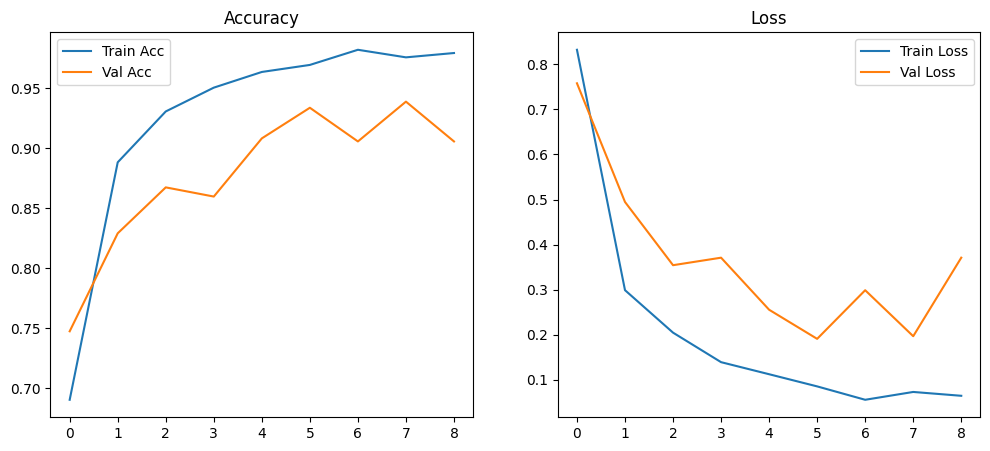

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.9444 - loss: 0.2058

✅ Test Accuracy: 93.57%
🧪 Test Loss: 0.2303
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 605ms/step

🧾 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.90      0.94       185
meningioma_tumor       0.91      0.93      0.92       188
        no_tumor       0.97      0.89      0.93       100
 pituitary_tumor       0.91      1.00      0.95       180

        accuracy                           0.94       653
       macro avg       0.94      0.93      0.93       653
    weighted avg       0.94      0.94      0.94       653



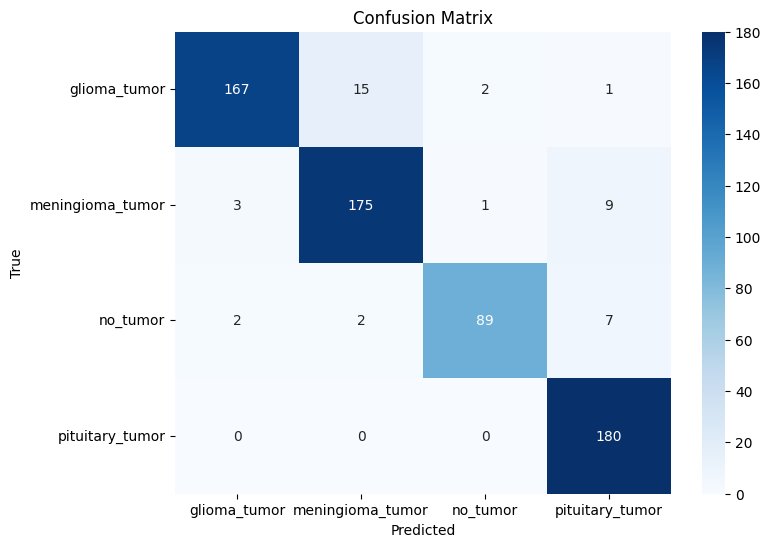

In [29]:
# ✅ Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
import glob

# ✅ Step 2: Paths & Parameters
DATASET_PATH = "/kaggle/input/sartaj-dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# ✅ Step 3: Load all image paths & labels (recursive search)
valid_exts = (".png", ".jpg", ".jpeg")
image_paths = glob.glob(os.path.join(DATASET_PATH, "**", "*.*"), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

if not image_paths:
    raise ValueError("❌ No images found. Check DATASET_PATH and file extensions.")

labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({"filename": image_paths, "class": labels})
print(f"✅ Total images: {len(df)}")
print(df['class'].value_counts())

# ✅ Step 4: Split dataset
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ✅ Step 5: Create ImageDataGenerators
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_flow = train_gen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                           target_size=IMG_SIZE, class_mode='categorical',
                                           batch_size=BATCH_SIZE)
val_flow = val_test_gen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, class_mode='categorical',
                                            batch_size=BATCH_SIZE)
test_flow = val_test_gen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                             target_size=IMG_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, shuffle=False)

# ✅ Step 6: Build the Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(len(train_flow.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# ✅ Step 7: Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Step 8: Train
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_densenet_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
]
history = model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# ✅ Step 9: Plot Training History
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# ✅ Step 10: Evaluate
loss, acc = model.evaluate(test_flow)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")
print(f"🧪 Test Loss: {loss:.4f}")

# ✅ Step 11: Predictions
y_true = test_flow.classes
y_pred = np.argmax(model.predict(test_flow), axis=1)
labels = list(test_flow.class_indices.keys())

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# ✅ Step 12: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 